# <p style="background-color: white; color:black;">Catastrophe ou non ?</p>

___

## <u style="color: blue">Sommaire</u>

1. Introduction
2. Néttoyage des données
3. Analyse exploratoire

___

## <u style="color: blue">1. Introduction</u>

Dans ce notebook vous trouverez nos travaux d'utilisation d'un modèle de machine learning pour prédire si un tweet est un tweet de catastrophe ou non. Dans un premier temps vous trouverez le détail de notre analyse de données puis, une fois le modèle entrainé, vous trouverez les résultats de nos prédictions.   

## <u style="color: blue">2. Nettoyage des données</u>

In [1]:
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import spacy
from spacy.vocab import Vocab

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import os
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from Decision_Tree import DecisionTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb



In [2]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
palette = sns.color_palette("rocket")

darker = palette[0]
dark = palette[1]
medium = palette[2]
redish = palette[3]
light = palette[4]
lighter = palette[5]

colors = ['green' if (i == 0 and j == 0) or (i == 1 and j == 1) else 'red' for i in range(2) for j in range(2)]
cmap_cm = ListedColormap(colors)

sns.set_style('darkgrid')

cmap = sns.color_palette("rocket", as_cmap=True)

In [4]:
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal', 'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'14', 'weight':'normal', 'color':'black', 'verticalalignment':'top'}
ticks_font = {'fontname':'Arial', 'size':'15', 'weight':'normal'}
legend_font = {'fontname':'Arial', 'size':'13', 'weight':'normal'}
label_font = {'fontname':'Arial', 'size':'12', 'weight':'normal'}

In [5]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'semibold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.labelspacing'] = 1
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.fancybox'] = True


On **<U>charge</u>** les données d'entrainement.

In [6]:
df_train = pd.read_csv('./CSV/train_tweets.csv')

df_test = pd.read_csv('./CSV/test_tweets.csv')

On **<u>visualise</u>** les 10 premières lignes du dataset pour voir à quoi il ressemble.

In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Ce csv nous donne des informations sur les tweets, notamment le texte du tweet, si il est classé comme étant un tweet de catastrophe ou non, et l'endroit où le tweet a été posté.

Nous **<U>vérifions</u>** s'il y a des valeurs manquantes dans le dataset.

On **<u>regarde</u>** la taille du dataset.

In [8]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

On **<u>remarque</u>** qu'il y a des valeurs manquantes dans les colonnes "keyword" et "location".

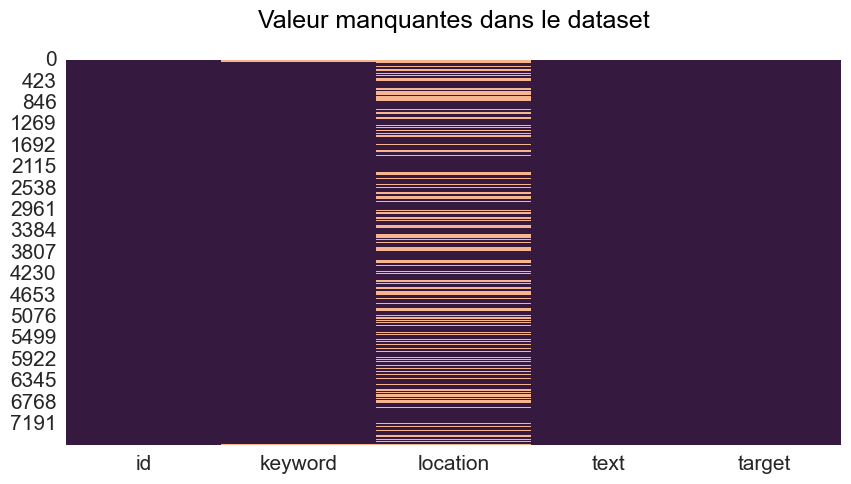

In [10]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_train.isnull(), cbar=False, cmap=palette)
plt.title('Valeur manquantes dans le dataset', fontdict=title_font)
plt.show()

On peut <u>**voir**</u> que la colonne "keyword" n'est pas renseiignée pour les premiers et derniers tweets du dataset.   
En revanche, la colonne "location" possède des valeurs manquantes sur l'ensemble du dataset.

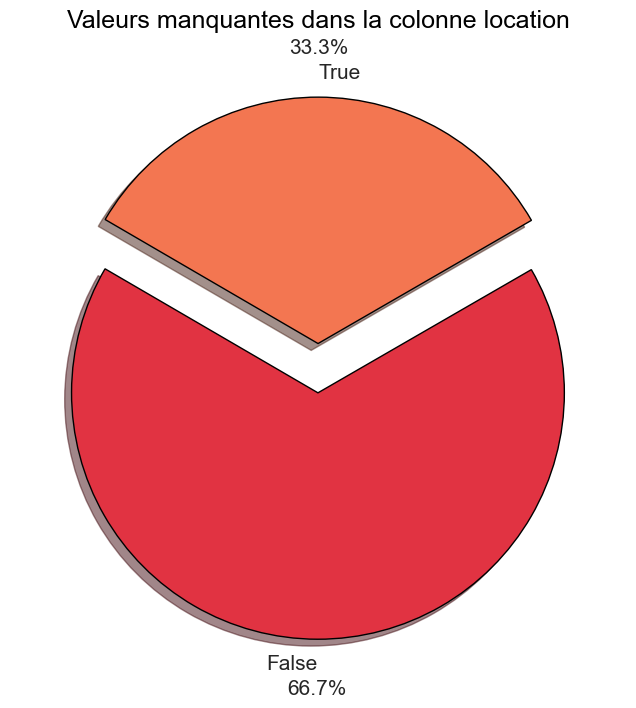

In [11]:
plt.figure(figsize=(10, 8))
df_train['location'].isnull().value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.2)
plt.title('Valeurs manquantes dans la colonne location', fontdict=title_font)
plt.ylabel('')
plt.show()

On <u>**remarque**</u> que la colonne "location" est vide à 33%.

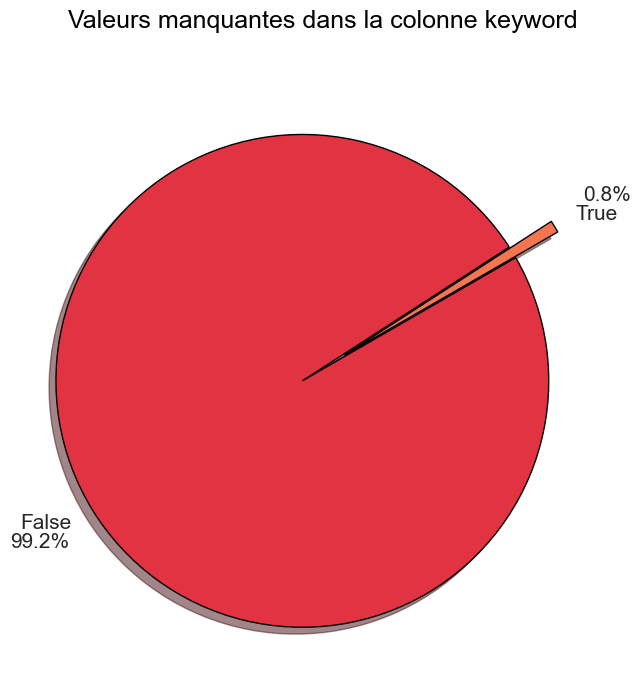

In [12]:
plt.figure(figsize=(10, 8))
df_train['keyword'].isnull().value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.25)
plt.title('Valeurs manquantes dans la colonne keyword', fontdict=title_font)
plt.ylabel('')
plt.show()

La colonne "keyword" est vide à 0.8%.

C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3140271278.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(hue=not_null.index, y=not_null, ax=ax[0], palette=palette, legend=False)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3140271278.py:5: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(hue=null.index, y=null, ax=ax[1], palette=palette, legend=False)


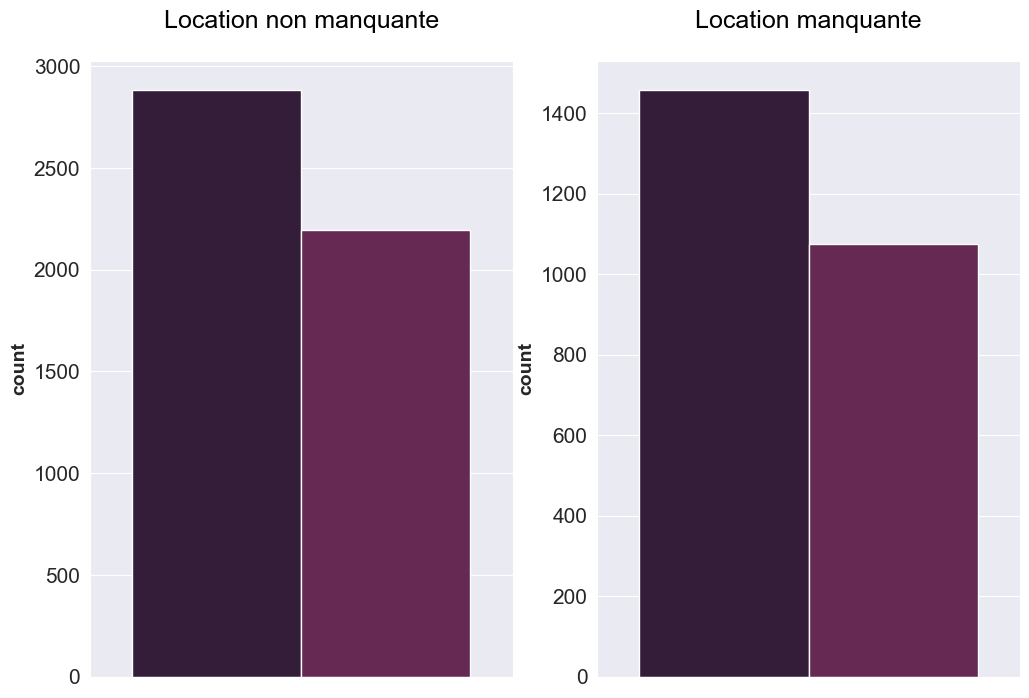

In [13]:
not_null = df_train[df_train['location'].notnull()]['target'].value_counts()
null = df_train[df_train['location'].isnull()]['target'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(hue=not_null.index, y=not_null, ax=ax[0], palette=palette, legend=False)
sns.barplot(hue=null.index, y=null, ax=ax[1], palette=palette, legend=False)
ax[0].set_title('Location non manquante', fontdict=title_font)
ax[1].set_title('Location manquante', fontdict=title_font)
plt.show()

Vérifions les <U>**doublons**</u>.

In [14]:
df_train['text'].duplicated().sum()

110

In [15]:
tweet_length = df_train[df_train['text'].duplicated()]['text'].apply(len)

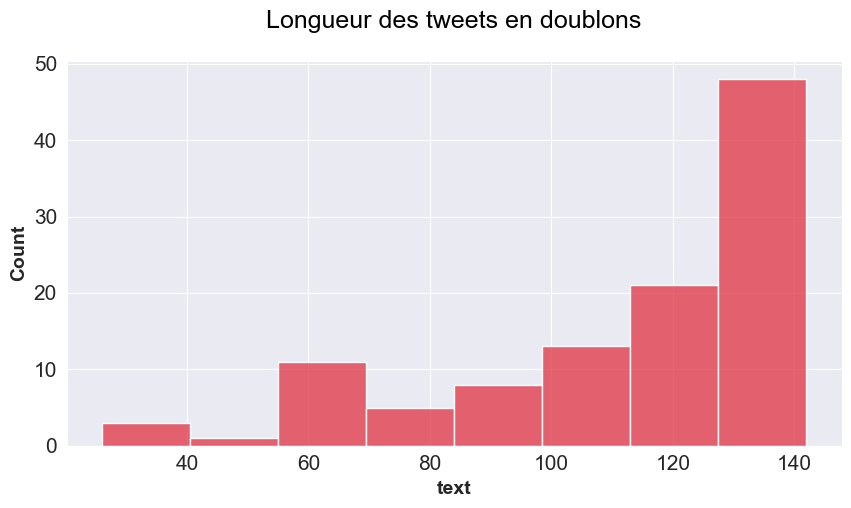

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(tweet_length, color=redish)
plt.title('Longueur des tweets en doublons', fontdict=title_font)
plt.show()

In [17]:
df_train['text'].duplicated().sum()

110

Nous <u>**choississons**</u> de supprimer les doublons.

In [18]:
df_train.drop_duplicates(subset='text', keep='first', inplace=True)

In [19]:
df_train.describe()

,id,target
count,7503.000000,7503.000000
mean,5439.831401,0.426230
std,3141.748725,0.494561
min,1.000000,0.000000
25%,2726.500000,0.000000
50%,5408.000000,0.000000
75%,8149.500000,1.000000
max,10873.000000,1.000000


Si nous supprimons les lignes ayant des valeurs nulles alors -> suppresion d'un tiers des données.   
Drop des colonnes ou remplacement par des valeurs par défaut ?

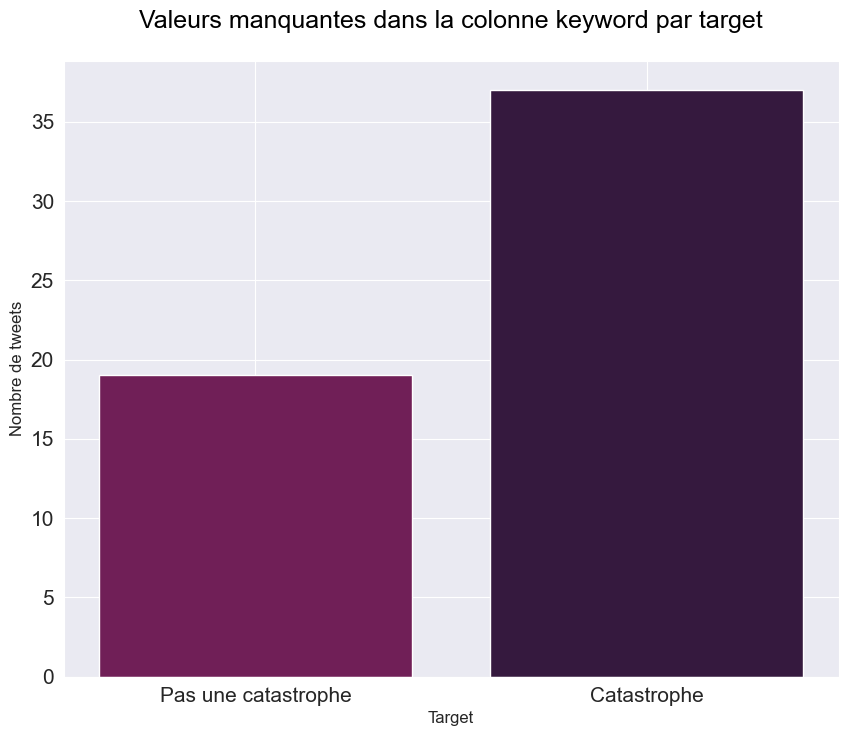

In [20]:
plt.figure(figsize=(10, 8))
plt.bar(df_train[df_train['keyword'].isnull()]['target'].value_counts().index, df_train[df_train['keyword'].isnull()]['target'].value_counts(), color=palette)
plt.title('Valeurs manquantes dans la colonne keyword par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

Il manque deux fois plus de mots clés pour les catastrophes que pour les tweets ne concernant pas des catastrophes.

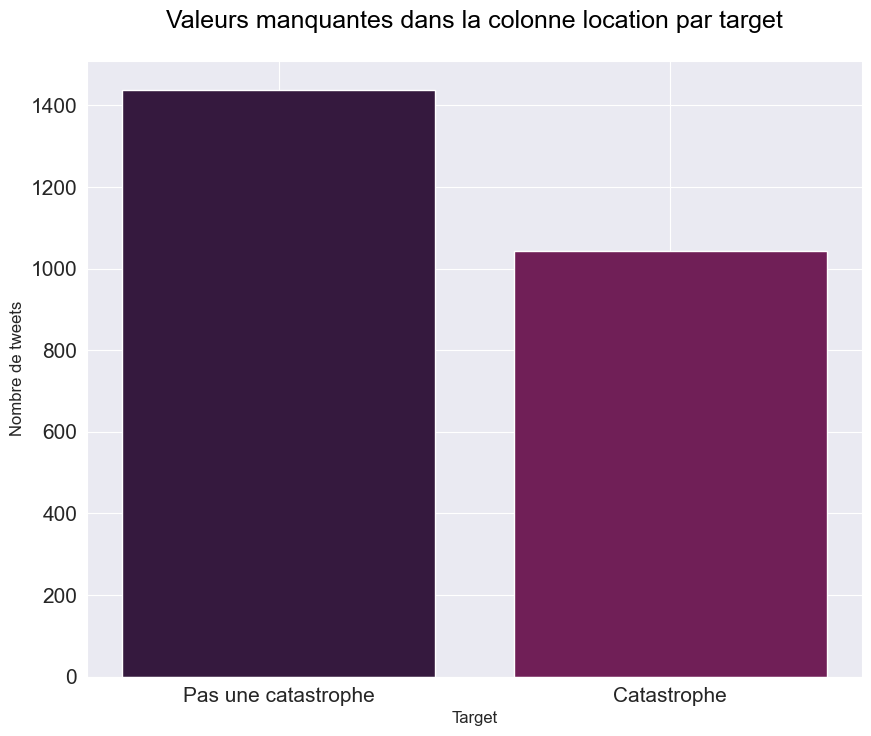

In [21]:
plt.figure(figsize=(10, 8))
plt.bar(df_train[df_train['location'].isnull()]['target'].value_counts().index, df_train[df_train['location'].isnull()]['target'].value_counts(), color=palette)
plt.title('Valeurs manquantes dans la colonne location par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

La localisation des tweets est moins renseignée pour les tweets qui ne sont pas des catastrophes.

La localisation des tweets n'est pas une information pertinente pour la prédiction de la cible. Nous allons donc supprimer cette colonne.

In [22]:
df_train.drop(columns='location', inplace=True)

In [23]:
df_train.isnull().sum()

id          0
keyword    56
text        0
target      0
dtype: int64

Nous allons maintenant remplacer les valeurs manquantes de la colonne "keyword" par "unknown".

In [24]:
df_train.fillna({'keyword': 'unknown'}, inplace=True)

## <u style="color: blue">3. Analyse exploratoire</u>

### Néttoyage des données

In [25]:
df_train['text'] = df_train['text'].str.replace(r'http\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'www.\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'@\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'#\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r't.co\S+', '', regex=True)

df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.replace(r'\b\w\b', '', regex=True).str.replace(r'\b\d+\b', '', regex=True)

### Nombre de stop words

Nous téléchargeons les stop words de la langue anglaise en utilisant la librairie nltk.

In [26]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


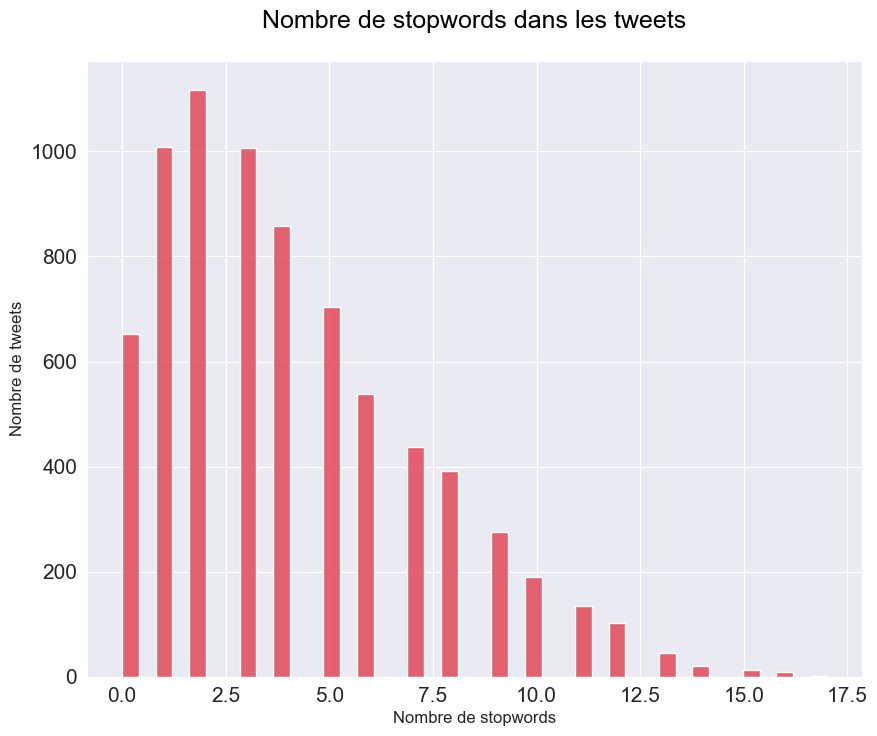

In [27]:
num_of_stop_words = df_train['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

plt.figure(figsize=(10, 8))
sns.histplot(num_of_stop_words, color=redish)
plt.title('Nombre de stopwords dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de stopwords', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nuage de mots

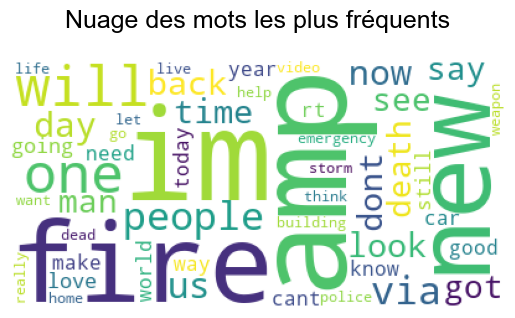

In [28]:
texte = ' '.join(df_train['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nuage des mots les plus fréquents', fontdict=title_font)
plt.show()

### Taille des tweets

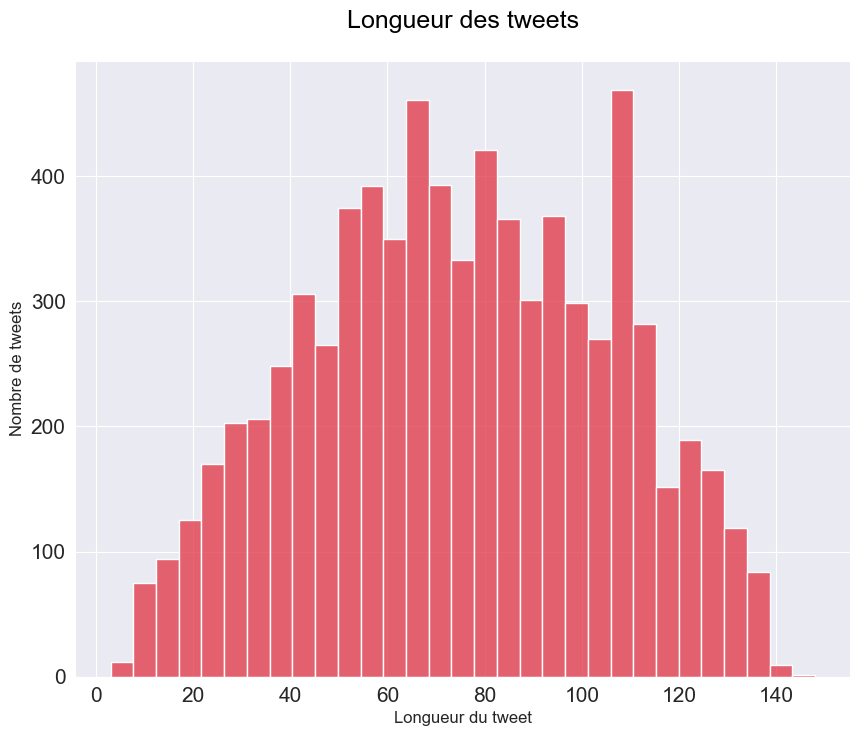

In [29]:
text_length = df_train['text'].apply(len)

plt.figure(figsize=(10, 8))
sns.histplot(text_length, color=redish)
plt.title('Longueur des tweets', fontdict=title_font)
plt.xlabel('Longueur du tweet', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombre de mots par tweets

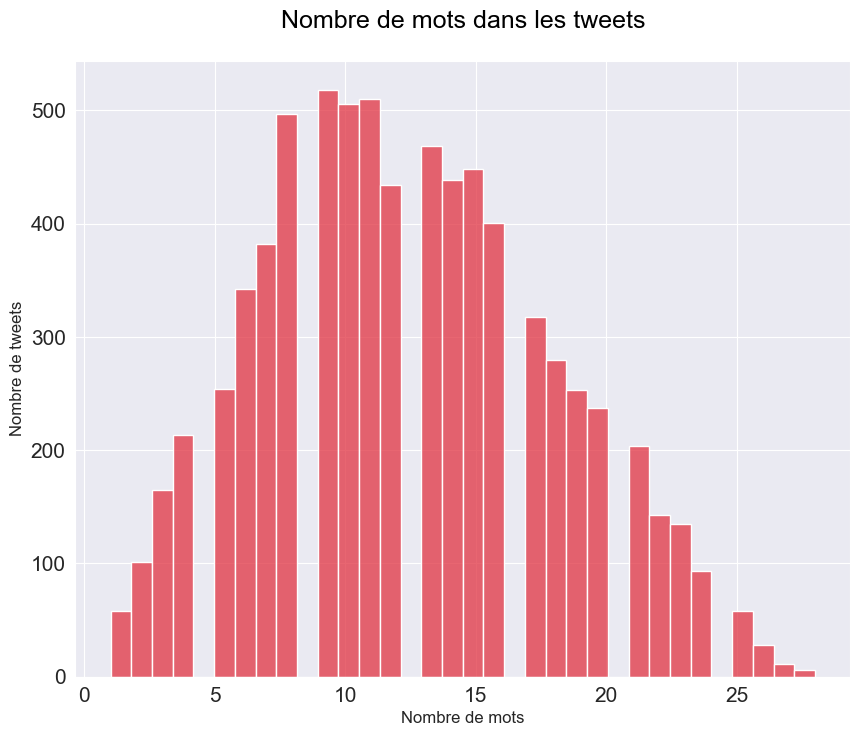

In [30]:
word_count = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 8))
sns.histplot(word_count, color=redish)
plt.title('Nombre de mots dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de mots', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombres de caractères par tweets

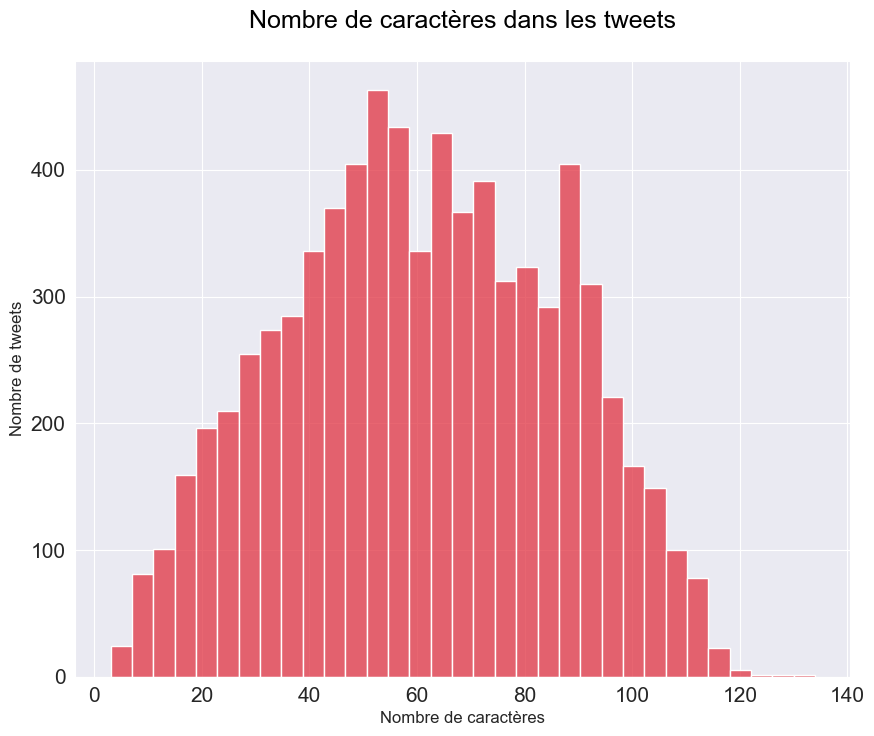

In [31]:
char_count = df_train['text'].apply(lambda x: len(x.replace(" ", "")))

plt.figure(figsize=(10, 8))
sns.histplot(char_count, color=redish)
plt.title('Nombre de caractères dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de caractères', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\1177417320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_train, palette=palette)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\1177417320.py:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x='target', data=df_train, palette=palette)


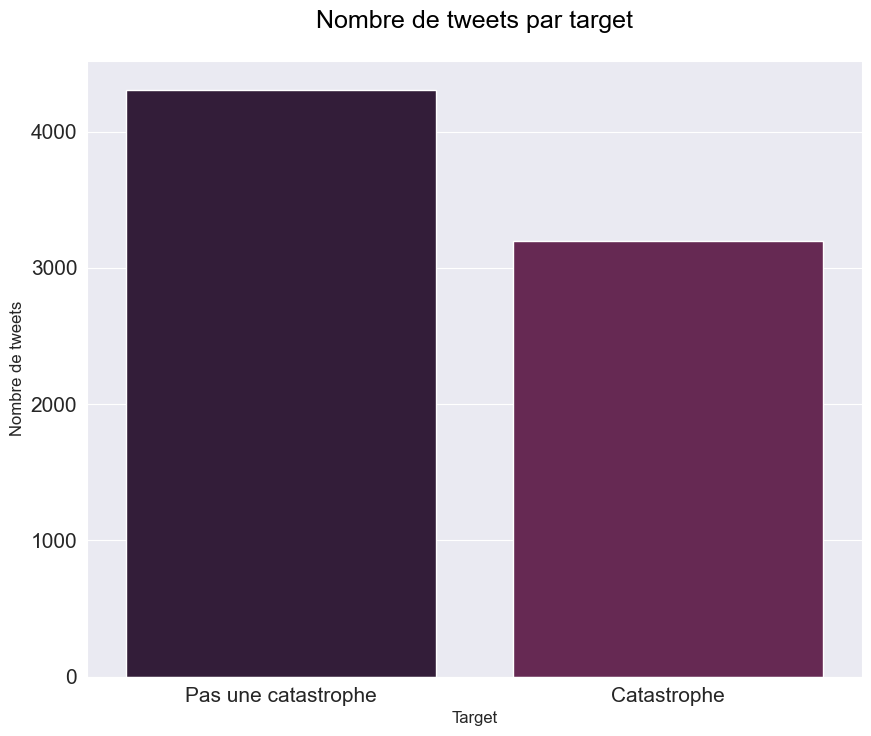

In [32]:
plt.figure(figsize=(10, 8))
sns.countplot(x='target', data=df_train, palette=palette)
plt.title('Nombre de tweets par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

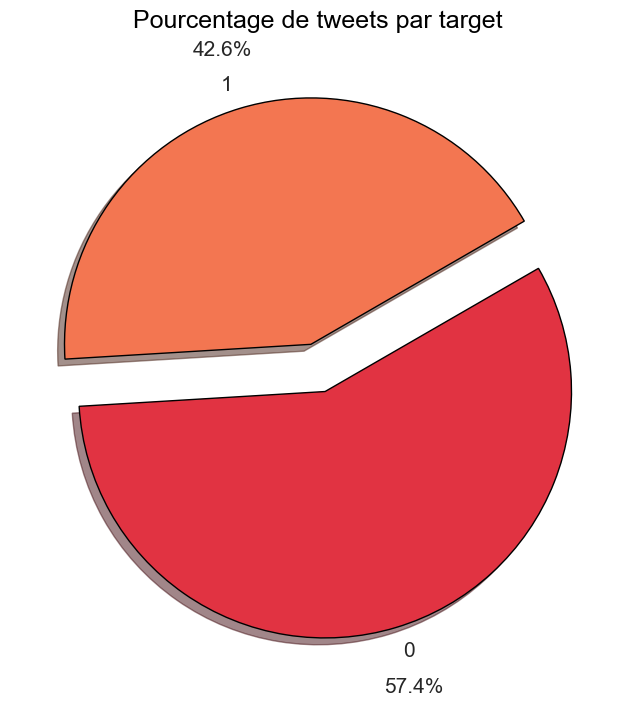

In [33]:
plt.figure(figsize=(10, 8))
df_train['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.25)
plt.title('Pourcentage de tweets par target', fontdict=title_font)
plt.ylabel('')
plt.show()

## <u style="color: blue">4. Préparation des données (Pipeline)</u>

Pour préparer nos données, je décide de boucler sur la colonne texte de faire des listes de mots, de les transformer en minuscules, de les tokeniser, de les stemmatiser et de les transformer en vecteurs.

Différence entre lemmatisation et stemming.

Stemming: méthode de normalisation de texte qui consiste à réduire les mots à leur racine ou à leur forme de base.   
Peut comporter des erreurs: plusieurs mots ayant des sens différents peuvent être réduits à la même racine: université, univers.

Lemmatisation: méthode de normalisation de texte qui consiste à réduire les mots à leur forme canonique.

In [34]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [35]:
stop_words.update(['im', 'u', 'amp', 'get', 'dont', 'go', 'one', 'like', 'new', 'via', 'would', 'us', 'love', 'got', 'know', 'cant', 'still', 'back', 'see', 'day', 'time', 'make', 'good', 'think', 'really', 'even', 'well', 'much', 'want', 'need', 'way', 'look', 'right', 'take', 'thing', 'come', 'year', 'let', 'say', 'every', 'people', 'many', 'great', 'could', 'use', 'may', 'never', 'first', 'best', 'last', 'ever', 'live', 'always', 'next', 'big', 'find', 'feel', 'watch', 'rt', 'lol', 'youtube', 'video', 'youre', 'check', 'thats', 'ive', 'hes'])

In [36]:
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [37]:
df_train['text']

0                              Deeds Reason ALLAH Forgive
1                   Forest fire near La Ronge Sask Canada
2       residents asked shelter place notified officer...
3                    receive evacuation orders California
4                      sent photo Ruby smoke pours school
                              ...                        
7604    Fallen powerlines Glink tram UPDATE FIRE crews...
7605    flip side Walmart bomb everyone evacuate stay ...
7606    Suicide bomber kills Saudi security site mosqu...
7608    Two giant cranes holding bridge collapse nearb...
7612    Latest Homes Razed Northern California Wildfir...
Name: text, Length: 7503, dtype: object

In [38]:
df_train['transformed_text'] = df_train['text'].apply(lambda x: x.lower().split())

In [39]:
df_train['transformed_text'] = df_train['transformed_text'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

df_train.head(10)

,id,keyword,text,target,transformed_text
0,1,unknown,Deeds Reason ALLAH Forgive,1,"[deed, reason, allah, forgiv]"
1,4,unknown,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, rong, sask, canada]"
2,5,unknown,residents asked shelter place notified officer...,1,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,unknown,receive evacuation orders California,1,"[receiv, evacu, order, california]"
4,7,unknown,sent photo Ruby smoke pours school,1,"[sent, photo, rubi, smoke, pour, school]"
5,8,unknown,Update California Hwy closed directions due La...,1,"[updat, california, hwi, close, direct, due, l..."
6,10,unknown,Heavy rain causes flash flooding streets Manit...,1,"[heavi, rain, caus, flash, flood, street, mani..."
7,13,unknown,top hill fire woods,1,"[top, hill, fire, wood]"
8,14,unknown,Theres emergency evacuation happening building...,1,"[there, emerg, evacu, happen, build, across, s..."
9,15,unknown,afraid tornado coming area,1,"[afraid, tornado, come, area]"


On récupère la racine des mots a l'aide de la stemmatisation.

In [40]:
df_train['keyword'].unique()

array(['unknown', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

In [41]:
print('Nombre de mots clés unique :', df_train['keyword'].nunique())

Nombre de mots clés unique : 222


In [42]:
print('Nombre de mots clés unique par target 1 :', df_train[df_train['target'] == 1]['keyword'].nunique())

Nombre de mots clés unique par target 1 : 221


In [43]:
print('Nombre de mots clés unique par target 0 :', df_train[df_train['target'] == 0]['keyword'].nunique())


Nombre de mots clés unique par target 0 : 219


Les keywords ne sont pas utiles dans le cadre de notre projet, en effet, ils existent 222 mots clés différents.   
221 d'entre eux sont des mots clés de catastrophe et 219 sont présents dans les tweets ne concernant pas des catastrophes.

Regardons par curiosité quels mots clés sont manquant dans les tweets de catastrophe. Et ensuite dans les tweets ne concernant pas des catastrophes.

In [44]:
unique_keywords = df_train['keyword'].unique()

print('Mots clés non présent dans target == 1 :')
for keyword in unique_keywords:
    if keyword not in df_train[df_train['target'] == 1]['keyword'].unique():
        print(keyword)

print()
print('Mots clés non présent dans target == 0 :')
for keyword in unique_keywords:
    if keyword not in df_train[df_train['target'] == 0]['keyword'].unique():
        print(keyword)


Mots clés non présent dans target == 1 :
aftershock

Mots clés non présent dans target == 0 :
debris
derailment
wreckage


In [45]:
df_train.drop(columns='keyword', inplace=True)

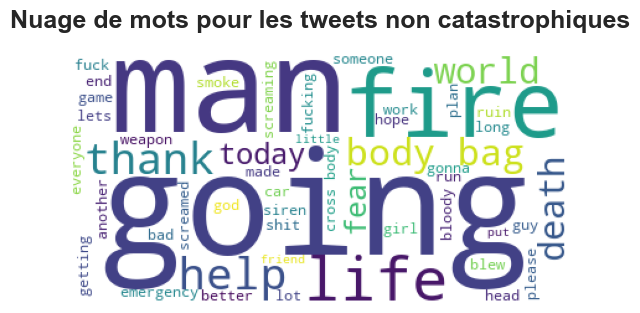

In [46]:
texte = ' '.join(df_train[df_train['target'] == 0]['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Nuage de mots pour les tweets non catastrophiques")
plt.show()

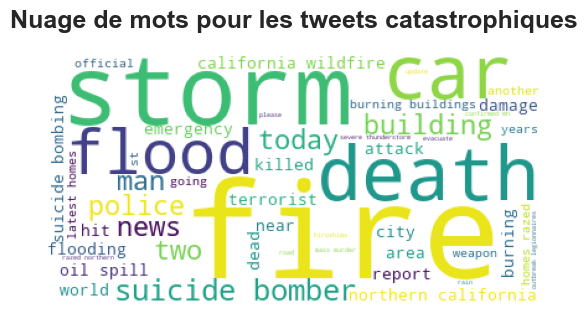

In [47]:
texte = ' '.join(df_train[df_train['target'] == 1]['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Nuage de mots pour les tweets catastrophiques")
plt.show()

Voici la pipeline de préparation des données une fois toutes les étapes effectuées.

In [50]:
def clean_duplicates(dataframe, column_name):
    print("clean_duplicates")
    return dataframe.drop_duplicates(subset=column_name, keep='first')

def clean_special_characters(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].str.replace(r'http\S+', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r'www.\S+', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r'@\S+', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r'#\S+', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r't.co\S+', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r'\b\w\b', '', regex=True)
    dataframe[column_name] = dataframe[column_name].str.replace(r'\b\d+\b', '', regex=True)

    return dataframe

def clean_stopwords(dataframe, column_name):
    print("clean_stopwords")
    stop_words = set(stopwords.words('english'))
    stop_words.update(['im', 'u', 'amp', 'get', 'dont', 'go', 'one', 'like', 'new', 'via', 'would', 'us', 'love', 'got', 'know', 'cant', 'still', 'back', 'see', 'day', 'time', 'make', 'good', 'think', 'really', 'even', 'well', 'much', 'want', 'need', 'way', 'look', 'right', 'take', 'thing', 'come', 'year', 'let', 'say', 'every', 'people', 'many', 'great', 'could', 'use', 'may', 'never', 'first', 'best', 'last', 'ever', 'live', 'always', 'next', 'big', 'find', 'feel', 'watch', 'rt', 'lol', 'youtube', 'video', 'youre', 'check', 'thats', 'ive', 'hes'])

    dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

    return dataframe

def tokenize(dataframe, column_name, new_column_name):
    print("tokenize")
    dataframe[new_column_name] = dataframe[column_name].apply(lambda x: word_tokenize(x))

    return dataframe

def stemmatized(dataframe, column_name, new_column_name):
    print("stemmatized")
    stemmer = PorterStemmer()
    dataframe[new_column_name] = dataframe[column_name].apply(lambda x: [stemmer.stem(word) for word in x])

    return dataframe

def vectorizer_TFIDF(dataframe, column_name, new_column_name):
    print("vectorizer_TFIDF")
    TFIDF = TfidfVectorizer(max_features=6678)
    vectorized_data = TFIDF.fit_transform([' '.join(text) for text in dataframe[column_name]]).toarray()

    average = np.mean(vectorized_data, axis=0)

    dataframe[new_column_name] = average

    return dataframe

def vectorizer_BoW(dataframe, column_name, new_column_name):
    print("vectorizer_BoW")
    cv = CountVectorizer(max_features=6678)
    vectorized_data = cv.fit_transform([' '.join(text) for text in dataframe[column_name]]).toarray()
    vectorized_list = vectorized_data.tolist()

    dataframe[new_column_name] = vectorized_list

    return dataframe

def vectorize_TFID_tweet(dataframe, column_name='text', new_column_name='vectorized_tweet_TFIDF'):
    print("vectorize_TFID_tweet")
    TFIDF = TfidfVectorizer(max_features=6678)
    vectorized_data = TFIDF.fit_transform(dataframe[column_name]).toarray()
    vectorized_list = vectorized_data.tolist()

    dataframe[new_column_name] = vectorized_list

    return dataframe

def list_to_string(dataframe, column_name):
    print("list_to_string")
    dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join(x))

    return dataframe


def pipeline(dataframe, column_name):
    print("pipeline")
    dataframe = clean_duplicates(dataframe, column_name)
    dataframe = clean_special_characters(dataframe, column_name)
    dataframe = clean_stopwords(dataframe, column_name)
    dataframe = tokenize(dataframe, column_name, 'transformed_text')
    dataframe = stemmatized(dataframe, 'transformed_text', 'stemmed_text')
    dataframe = list_to_string(dataframe, 'stemmed_text')
    # dataframe = vectorizer_TFIDF(dataframe, 'stemmed_text', 'vectorized_text_TFIDF')
    # dataframe = vectorize_TFID_tweet(dataframe, column_name='text', new_column_name='vectorized_tweet_TFIDF')
    # dataframe = vectorizer_BoW(dataframe, 'stemmed_text', 'vectorized_text_BoW')

    return dataframe

In [51]:
df_train = pipeline(df_train, 'text')
df_test = pipeline(df_test, 'text')

df_train.head()

pipeline
clean_duplicates
clean_stopwords


C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name] = dataframe[column_name].str.replace(r'http\S+', '', regex=True)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name] = dataframe[column_name].str.replace(r'www.\S+', '', regex=True)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:8: SettingWithCopyWarning: 
A value is trying to be set

tokenize


C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[new_column_name] = dataframe[column_name].apply(lambda x: word_tokenize(x))


stemmatized


C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[new_column_name] = dataframe[column_name].apply(lambda x: [stemmer.stem(word) for word in x])
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join(x))
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:6: SettingWithCopyWarning: 
A value is trying to

list_to_string
pipeline
clean_duplicates
clean_stopwords
tokenize


C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[new_column_name] = dataframe[column_name].apply(lambda x: word_tokenize(x))


stemmatized
list_to_string


C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[new_column_name] = dataframe[column_name].apply(lambda x: [stemmer.stem(word) for word in x])
C:\Users\x_mat\AppData\Local\Temp\ipykernel_52\3635844012.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join(x))


,id,text,target,transformed_text,stemmed_text
0,1,Deeds Reason ALLAH Forgive,1,"[Deeds, Reason, ALLAH, Forgive]",deed reason allah forgiv
1,4,Forest fire near La Ronge Sask Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]",forest fire near la rong sask canada
2,5,residents asked shelter place notified officer...,1,"[residents, asked, shelter, place, notified, o...",resid ask shelter place notifi offic evacu she...
3,6,receive evacuation orders California,1,"[receive, evacuation, orders, California]",receiv evacu order california
4,7,sent photo Ruby smoke pours school,1,"[sent, photo, Ruby, smoke, pours, school]",sent photo rubi smoke pour school


In [52]:
vectorizer = TfidfVectorizer(max_features=6678)
X = vectorizer.fit_transform(df_train['stemmed_text']).toarray()
X_test = vectorizer.transform(df_test['stemmed_text']).toarray()

y = df_train['target']

## <u style="color: blue">5. Adaptation de l'analyse exploratoire suite aux modifications</u>

### Nuage de mots après suppression des stop words.

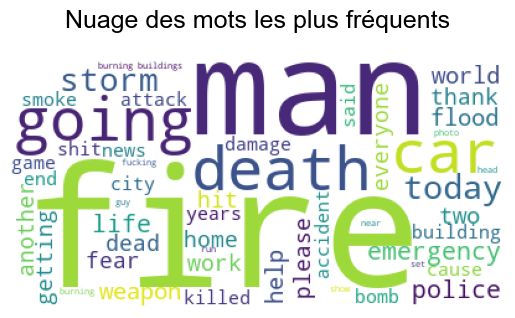

In [53]:
texte = ' '.join(df_train['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nuage des mots les plus fréquents', fontdict=title_font)
plt.show()

### Taille des tweets après suppression des stop words

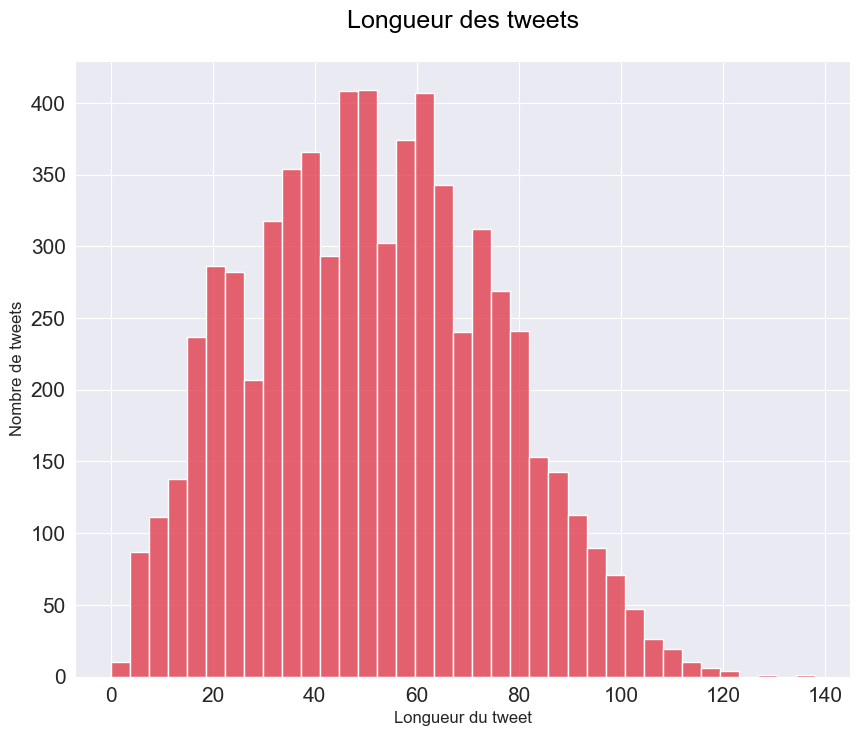

In [54]:
text_length = df_train['text'].apply(len)

plt.figure(figsize=(10, 8))
sns.histplot(text_length, color=redish)
plt.title('Longueur des tweets', fontdict=title_font)
plt.xlabel('Longueur du tweet', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombre de mots par tweets après suppression des stop words

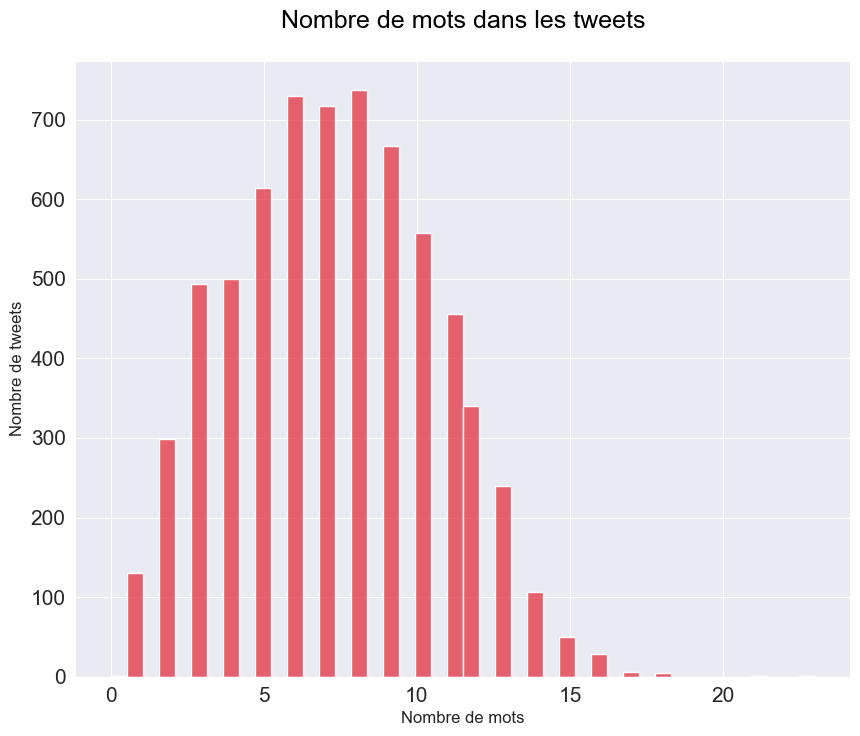

In [55]:
word_count = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 8))
sns.histplot(word_count, color=redish)
plt.title('Nombre de mots dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de mots', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombres de caractères par tweets après suppression des stop words

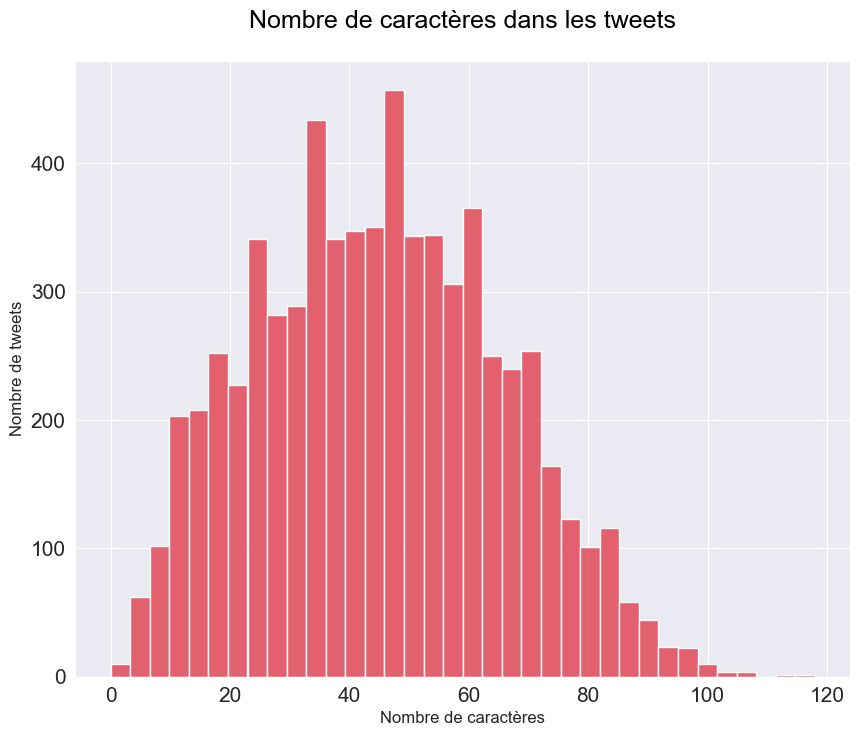

In [56]:
char_count = df_train['text'].apply(lambda x: len(x.replace(" ", "")))

plt.figure(figsize=(10, 8))
sns.histplot(char_count, color=redish)
plt.title('Nombre de caractères dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de caractères', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

In [57]:
X = df_train['stemmed_text']
y = df_train['target']

## <u style="color: blue">6. Etudes des modèles d'apprentissage</u>

### 1. Modèle de régression logistique

Rappel: la régression logistique est un modèle de classification binaire.   
Permet d'étudier les relations entre un ensemble de variable qualitative X et une variable qualitative Y (binaire).

### 2. Modèle de forêt aléatoire

Le model random forest est un modèle d'apprentissage composé de dizaines voire de centaines d'arbres de décision.   
Le nombre d'arbres est un hyperparamètre du modèle ajusté par validation croisée.   
Chaque arbre est entrainé sur un sous-ensemble aléatoire des données d'entrainement.   
Les résultats de tous les arbres de décision sont alors combinés pour donner une réponse finale.   
Chaque arbre "vote" (oui ou non) pour la classe prédite et la réponse finale est celle qui a eu la majorité de vote.   
C'est une méthode dite "de bagging".

### 3. Modèle d'arbres de décision

L'algorithme des arbres de décision est une méthode classique en apprentissage automatique.   
Son but est de créer un modèle qui prédit la valeur d'une variable-cible à partir de la valeur de plusieurs variables d'entrée.   
Une des variable d'entrée est sélectionné à chaque noeud (non terminal) de l'arbre en fonction de son importance.   
Chaque feuille de l'arbre représente soit une valeur de la variable-cible soit une distribution de probabilité des diverses valeurs possibles de la variable-cible.

<font color='red'>**ALGORITHME GLOUTON**</font>

### 4. Modèle de XGBoost

La méthode XGBoost (eXtreme Gradient Boosting) est une méthode utilisé pour résoudre les problèmes de classification ou de régression.   
C'est un modèle amélioré de l'algorithme d'amplification de gradient (Gradient Boost).   
Il est également utilisé pour résoudre les problématiques courantes d'entreprises tout en se basant sur une quantité minimale de ressources.   
C'est aussi un assemblage d'arbres décisionnels qui prédisent les résidus et corrige les erreurs des arbres décisionnels précédents.

### 5. Modèle de SVM

Les SVM (Support Vector Machine) sont une famille d'algorithmes d'apprentissage automatique qui permettent de résoudre des problèmes tant de classification que de régression ou de détection d'anomalies.   
Le principe des SVM est de trouver une frontière aussi "simple" que possible de telle façon que la distance entre les différents groupes de données et la frontière soit maximale.   
Cette distance est aussi appelée "marge" et les SVMs sont ainsi qualifiés de "séparateurs à vaste marge", les "vecteurs de support" étant les points les plus proches de la frontière.

### 6. Bagging (une méthode avec fonctionnement parallèle)

Le bagging qui signifie "Bootstrap AGGregatING" est une méthode d'ensemble qui consiste à entraîner plusieurs modèles sur des sous-ensembles aléatoires des données d'entraînement.   
- Le bootstrap est une méthode qui consiste à créer de nouveau jeu de données à partir du jeu de données initial en tirant aléatoirement des échantillons présent dans le jeu de données initial, le même élément peut être sélectionner plusieurs fois.   
Le nouveau jeu de donnée est de même taille que le jeu de données initial.
- L'agrégation de données consiste à combiner les résultats des différents modèles créés a l'aide du bootstrap afin de créer un modèle final, cette combinaison peut se faire par moyenne, vote majoritaire, etc.

### 7. Boosting (une méthode avec fonctionnement séquentiel)

Le boosting est une méthode d'ensemble qui consiste à entraîner plusieurs modèles de manière séquentielle, la différence majeure avec le bagging est que les différents classifieurs sont pondérés de manière à ce que les classifieurs ayant prédit correctement les données précédentes aient un poids plus important que ceux avec des prédictions incorrectes.

NOTA: La partie sur le grid search demandant plus de temps de calcul, nous avons décidé de la séparer de ce notebook et de l'inculre dans un autre notebook.   
Nous allons dans ce cas enregistrer le dataframe dans un nouveau fichier csv afin de ne pas avoir refaire l'analyse exploratoire à chaque fois.

In [58]:
# save dataframe in a new csv file
df_train.to_csv('./CSV/train_tweets_cleaned.csv', index=False)

## <u style="color: blue">[7. Gridsearch](./GridSearch.ipynb#7.-Gridsearch)</u>

## <u style="color: blue">8. Evaluation des modèles</u>